<a href="https://colab.research.google.com/github/kumar-sam/Job-Description-classification-BERT/blob/master/bert_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
%tensorflow_version 1.x

In [81]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

### 1. Data Preperation

In [22]:
#importing the library
import re
import nltk
import numpy as np
import pandas as pd
from nltk import word_tokenize
np.random.seed(1337)
from keras import Sequential
from keras.utils import Sequence
from keras.layers import LSTM, Dense, Masking
import numpy as np
import keras
from keras.utils import np_utils
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Embedding, Dense, Input, concatenate, Layer, Lambda, Dropout, Activation
import datetime
from datetime import datetime
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, TensorBoard
import tensorflow as tf
import tensorflow_hub as hub

In [23]:
df = pd.read_excel("/content/dataset_jd.xlsx")
df.head(2)

,JD Type,TITLE,JD
0,T,Software Developer,"Minimum Required Skills:C/C#/C++, Java/J2EE, G..."
1,T,Mechanical Engineer,Interested please share resumes ASAP. Call 301...


In [24]:
for jd in df.JD.values[3000:3005]:
  print(jd)

<P style="TEXT-ALIGN: center"><STRONG>GOWIRELESS<BR>\r <BR>\r</STRONG><EM>Looking for a rewarding sales opportunity? Like to be rewarded for your efforts? How about an uncapped earning potential? <STRONG>GoWireless</STRONG> has it all. <BR>\rWe are offering sales management and retail supervisory professionals an exciting opportunity for growth with one of the leading providers of wireless products, services and accessories in the US<STRONG> </STRONG>market.</EM> </P>\r<STRONG>\r<CENTER>\r<HR>\r</CENTER>\r<CENTER><STRONG> </STRONG></CENTER></STRONG>\r<CENTER><STRONG>ABOUT US</STRONG></CENTER>\r<CENTER><BR>\r<EM><STRONG>GoWireless</STRONG> is one of the most comprehensive sources of wireless products and services. Marketing wireless products and services online and through its nationwide traditional retail operation, <STRONG>GoWireless</STRONG> is one of the largest wireless phone retailers and a major retailer in the US. <BR>\rFounded in Southern California in 1995, GoWireless has cont

In [25]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [26]:
TAG_RE = re.compile(r'<[^>]+>')
def remove_tags(text):
    return TAG_RE.sub(' ', text)


import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
stop_words = stopwords.words('english')

In [28]:
df['JD'] =df['JD'].apply(remove_tags)

In [29]:
def preprocessJob(job_desc):
    """
        processess the document text by removing punct, digits,
        replaces phrase skill words with underscore, removes stop_words
        """
    global stop_words

    #replacing html based space(&nbsp)
    job_desc = job_desc.replace('&nbsp', ' ')

    #dealing with unicode char
    job_desc = job_desc.replace(u'\xa0', u' ')
    job_desc = re.sub(r'[^\x00-\x7F]',' ', job_desc)

    # Removes non-alphabetic characters excluding _
    job_desc= re.sub('[^.A-Za-z]', ' ', job_desc)
    #replacing multiple space with single space
    job_desc = re.sub('\s+', ' ', job_desc)

    tokens = word_tokenize(str(job_desc))
    result = [token for token in tokens if token not in stop_words]
    result = " ".join(result)
    return result


In [30]:
df['JD'] =df['JD'].apply(preprocessJob)

In [31]:
for jd in df.JD.values[3000:3005]:
  print(jd)

GOWIRELESS r r Looking rewarding sales opportunity Like rewarded efforts How uncapped earning potential GoWireless . rWe offering sales management retail supervisory professionals exciting opportunity growth one leading providers wireless products services accessories US market . r r r r r r ABOUT US r r GoWireless one comprehensive sources wireless products services . Marketing wireless products services online nationwide traditional retail operation GoWireless one largest wireless phone retailers major retailer US . rFounded Southern California GoWireless continually strived driving force wireless industry . Upon opening first store GoWireless helped bridge gap commonly seen paging cellular company continually done year year incorporating new emerging technologies across country . Today GoWireless continues grow steadfast stores throughout United States . r r GoWireless innovative date cutting edge technology gives patrons instant power experience next generation communication ease .

In [32]:
df.to_excel("/content/clean_dataset_jd.xlsx")

In [33]:
df.head(3)

,JD Type,TITLE,JD
0,T,Software Developer,Minimum Required Skills C C C Java J EE GUI De...
1,T,Mechanical Engineer,Interested please share resumes ASAP . Call fa...
2,T,Product Engineer,Responsibilities Designing developing products...


In [34]:
df = df[['JD','JD Type']]

In [35]:
df.head(3)

,JD,JD Type
0,Minimum Required Skills C C C Java J EE GUI De...,T
1,Interested please share resumes ASAP . Call fa...,T
2,Responsibilities Designing developing products...,T


In [36]:
df.rename(columns={"JD": "text", "JD Type": "label"}, inplace=True, errors="raise")

In [37]:
df.head(3)

,text,label
0,Minimum Required Skills C C C Java J EE GUI De...,T
1,Interested please share resumes ASAP . Call fa...,T
2,Responsibilities Designing developing products...,T


In [38]:
def trim_label(label):
  return label.strip()

In [39]:
df['label'] = df['label'].apply(trim_label)

In [40]:
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
df['label'] = LE.fit_transform(df['label'])
df.head()

,text,label
0,Minimum Required Skills C C C Java J EE GUI De...,1
1,Interested please share resumes ASAP . Call fa...,1
2,Responsibilities Designing developing products...,1
3,Serves liaison internal external business comm...,0
4,Company DescriptionWinning Edge Solutions tech...,1


In [41]:
df.shape

(3608, 2)

In [42]:
df.label.value_counts()

1    1963
0    1645
Name: label, dtype: int64

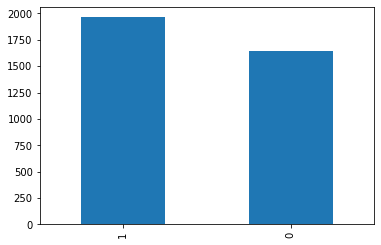

In [43]:
df.label.value_counts().plot(kind='bar')

In [44]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(df, test_size=0.2, random_state=35)
train.head()

,text,label
2437,Minimum Required Skills Photoshop Front End De...,1
584,With years business Group One Trading leading ...,0
1322,Entry Help Desk Coordinator Skills years exper...,0
1625,Minimum Required Skills REST APIs Agile Java U...,1
1841,RESPONSIBILITIES Kforce client searching Help ...,1


In [45]:
print("Train shape: {}".format(train.shape))
print("Test shape: {}".format(val.shape))

Train shape: (2886, 2)
Test shape: (722, 2)


In [46]:
train.reset_index(drop=True, inplace=True)
train.head(2)

,text,label
0,Minimum Required Skills Photoshop Front End De...,1
1,With years business Group One Trading leading ...,0


In [47]:
val.reset_index(drop=True, inplace=True)
val.head(2)

,text,label
0,Minimum Required Skills Linux DevOps Chef Pupp...,1
1,Skills Mandatory PreferableTechnical Skills ye...,1


In [48]:
train.shape, val.shape

((2886, 2), (722, 2))

In [49]:
#Installing BERT module
!pip install bert-tensorflow

In [50]:
#Importing BERT modules
import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization

In [51]:
# Set the output directory for saving model file
OUTPUT_DIR = '/content/bert_jd_category'

#@markdown Whether or not to clear/delete the directory and create a new one
DO_DELETE = True #@param {type:"boolean"}

if DO_DELETE:
  try:
    tf.gfile.DeleteRecursively(OUTPUT_DIR)
  except:
    pass

tf.gfile.MakeDirs(OUTPUT_DIR)

In [52]:
# Splitting the Data into smaller chunks
def get_split(text1):
  l_total = []
  l_parcial = []
  if len(text1.split())//150 >0:
    n = len(text1.split())//150
  else: 
    n = 1
  for w in range(n):
    if w == 0:
      l_parcial = text1.split()[:200]
      l_total.append(" ".join(l_parcial))
    else:
      l_parcial = text1.split()[w*150:w*150 + 200]
      l_total.append(" ".join(l_parcial))
  return l_total

In [53]:
train['text_split'] = train['text'].apply(get_split)
train.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,text,label,text_split
0,Minimum Required Skills Photoshop Front End De...,1,[Minimum Required Skills Photoshop Front End D...
1,With years business Group One Trading leading ...,0,[With years business Group One Trading leading...
2,Entry Help Desk Coordinator Skills years exper...,0,[Entry Help Desk Coordinator Skills years expe...
3,Minimum Required Skills REST APIs Agile Java U...,1,[Minimum Required Skills REST APIs Agile Java ...
4,RESPONSIBILITIES Kforce client searching Help ...,1,[RESPONSIBILITIES Kforce client searching Help...


In [54]:
val['text_split'] = val['text'].apply(get_split)
val.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,text,label,text_split
0,Minimum Required Skills Linux DevOps Chef Pupp...,1,[Minimum Required Skills Linux DevOps Chef Pup...
1,Skills Mandatory PreferableTechnical Skills ye...,1,[Skills Mandatory PreferableTechnical Skills y...
2,Title .NET Developer Location Boca Raton FL Du...,1,[Title .NET Developer Location Boca Raton FL D...
3,Location Rocklin CAPosition Senior Developer T...,1,[Location Rocklin CAPosition Senior Developer ...
4,Duties Migrating SQL Server data warehouse AWS...,1,[Duties Migrating SQL Server data warehouse AW...


In [55]:
val['text_split'].values[0]

['Minimum Required Skills Linux DevOps Chef Puppet Ruby Ansible Shell Scripting VMWare ESX ESXi JIRA Maven Jenkins Hudson HadoopIf DevOps Engineer open full time role contract exceptional scripting Linux skills please read Based outside Atlanta near Roswell award winning systems integrator working heavily DevOps Cloud Big Data Middleware Mobile technologies . Since focus help customers modernize optimize workloads new cloud world . Our team specializes migrating applications modernizing optimizing infrastructure enhancing manageability orchestration automationRight seeking someone join team travel bit work customers collaborate smart engineering team working heavily Linux environment.Top Reasons Work Us . Generous compensation solid benefits Medical Dental Vision PTO k w Match Profit Sharing tons . You working new technologies meeting new people networking customer base . . Opportunity work wide variety stacks including Hadoop VMware Ruby Shell Scripting name few.What You Will Be Doing

In [56]:
print("Training Set Shape :", train.shape)
print("Validation Set Shape :", val.shape)

Training Set Shape : (2886, 3)
Validation Set Shape : (722, 3)


In [57]:
train_l = []
label_l = []
index_l =[]
for idx,row in train.iterrows():
  for l in row['text_split']:
    train_l.append(l)
    label_l.append(row['label'])
    index_l.append(idx)
len(train_l), len(label_l), len(index_l)

(3722, 3722, 3722)

In [58]:
val_l = []
val_label_l = []
val_index_l = []
for idx,row in val.iterrows():
  for l in row['text_split']:
    val_l.append(l)
    val_label_l.append(row['label'])
    val_index_l.append(idx)
len(val_l), len(val_label_l), len(val_index_l)


(919, 919, 919)

In [59]:
DATA_COLUMN = 'text'
LABEL_COLUMN = 'label'
label_list = [x for x in np.unique(train.label)]
label_list

[0, 1]

In [60]:
train_df = pd.DataFrame({DATA_COLUMN:train_l, LABEL_COLUMN:label_l})
train_df.head()

,text,label
0,Minimum Required Skills Photoshop Front End De...,1
1,environment paid vacataion What You Will Be Do...,1
2,With years business Group One Trading leading ...,0
3,Entry Help Desk Coordinator Skills years exper...,0
4,Minimum Required Skills REST APIs Agile Java U...,1


In [61]:
val_df = pd.DataFrame({DATA_COLUMN:val_l, LABEL_COLUMN:val_label_l})
val_df.head()

,text,label
0,Minimum Required Skills Linux DevOps Chef Pupp...,1
1,cutting edge technology solutions.What You Nee...,1
2,Skills Mandatory PreferableTechnical Skills ye...,1
3,Title .NET Developer Location Boca Raton FL Du...,1
4,SQL Server TSQL Xml Xslt Object Oriented Analy...,1


### 2. BERT: Data Preprocessing

In [62]:
# outcome for Data Preprocessing is train_df and val_df
print("Training Set Shape :", train_df.shape)
print("Validation Set Shape :", val_df.shape)

Training Set Shape : (3722, 2)
Validation Set Shape : (919, 2)


In [63]:
#Process the data for BERT
train_InputExamples = train_df.apply(lambda x: bert.run_classifier.InputExample(guid=None,
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

val_InputExamples = val_df.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

In [64]:
train_InputExamples

0       <bert.run_classifier.InputExample object at 0x...
1       <bert.run_classifier.InputExample object at 0x...
2       <bert.run_classifier.InputExample object at 0x...
3       <bert.run_classifier.InputExample object at 0x...
4       <bert.run_classifier.InputExample object at 0x...
                              ...                        
3717    <bert.run_classifier.InputExample object at 0x...
3718    <bert.run_classifier.InputExample object at 0x...
3719    <bert.run_classifier.InputExample object at 0x...
3720    <bert.run_classifier.InputExample object at 0x...
3721    <bert.run_classifier.InputExample object at 0x...
Length: 3722, dtype: object

In [65]:
print("Row 0 - guid of training set : ", train_InputExamples.iloc[0].guid)
print("\n__________\nRow 0 - text_a of training set : ", train_InputExamples.iloc[0].text_a)
print("\n__________\nRow 0 - text_b of training set : ", train_InputExamples.iloc[0].text_b)
print("\n__________\nRow 0 - label of training set : ", train_InputExamples.iloc[0].label)

Row 0 - guid of training set :  None

__________
Row 0 - text_a of training set :  Minimum Required Skills Photoshop Front End Development JavaScript JQuery HTML CSS Wireframes Mock ups Prototypes AJAX UX Development EXT JS If UX Developer experience please read Based Carlsbad CA one fastest growing supply chain intelligence companies hit market . We well funded well established company growing rapidly unique target market using cloud based technology collect analyze distribute big data supply chain intelligence order optimize efficiency logistics supply chain companies country . We excellent leadership made company flourishing San Diego area . Currently seeking highly skilled UX Developer experience Front End Development User Interface User Experience development Javascript .JS D . If strong working HTML HTML CSS CSS .JS Ext JS D skills listed read . We need someone extensive experience UI UX web development skills would love opportunity speak amazing opportunityTop Reasons Work Us Co

### 3. BERT: Loading the pre-trained model

In [66]:
# This is a path to an uncased (all lowercase) version of BERT
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

def create_tokenizer_from_hub_module():
  """Get the vocab file and casing info from the Hub module."""
  with tf.Graph().as_default():
    bert_module = hub.Module(BERT_MODEL_HUB)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.Session() as sess:
      vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
  return bert.tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [67]:
len(tokenizer.vocab.keys())

30522

In [68]:
train_InputExamples.iloc[0].text_a

'Minimum Required Skills Photoshop Front End Development JavaScript JQuery HTML CSS Wireframes Mock ups Prototypes AJAX UX Development EXT JS If UX Developer experience please read Based Carlsbad CA one fastest growing supply chain intelligence companies hit market . We well funded well established company growing rapidly unique target market using cloud based technology collect analyze distribute big data supply chain intelligence order optimize efficiency logistics supply chain companies country . We excellent leadership made company flourishing San Diego area . Currently seeking highly skilled UX Developer experience Front End Development User Interface User Experience development Javascript .JS D . If strong working HTML HTML CSS CSS .JS Ext JS D skills listed read . We need someone extensive experience UI UX web development skills would love opportunity speak amazing opportunityTop Reasons Work Us Competitive Salary Great Benefits Brand New MAC PC hired work Flexible hours schedul

In [69]:
print(tokenizer.tokenize(train_InputExamples.iloc[0].text_a))

['minimum', 'required', 'skills', 'photos', '##hop', 'front', 'end', 'development', 'java', '##script', 'j', '##que', '##ry', 'html', 'cs', '##s', 'wire', '##frame', '##s', 'mock', 'ups', 'prototypes', 'ajax', 'u', '##x', 'development', 'ex', '##t', 'j', '##s', 'if', 'u', '##x', 'developer', 'experience', 'please', 'read', 'based', 'carl', '##sb', '##ad', 'ca', 'one', 'fastest', 'growing', 'supply', 'chain', 'intelligence', 'companies', 'hit', 'market', '.', 'we', 'well', 'funded', 'well', 'established', 'company', 'growing', 'rapidly', 'unique', 'target', 'market', 'using', 'cloud', 'based', 'technology', 'collect', 'analyze', 'distribute', 'big', 'data', 'supply', 'chain', 'intelligence', 'order', 'opt', '##imi', '##ze', 'efficiency', 'logistics', 'supply', 'chain', 'companies', 'country', '.', 'we', 'excellent', 'leadership', 'made', 'company', 'flourishing', 'san', 'diego', 'area', '.', 'currently', 'seeking', 'highly', 'skilled', 'u', '##x', 'developer', 'experience', 'front', 'en

In [70]:
MAX_SEQ_LENGTH = 200

In [72]:
# Convert our train and validation features to InputFeatures that BERT understands.
train_features = bert.run_classifier.convert_examples_to_features(train_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

val_features = bert.run_classifier.convert_examples_to_features(val_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

INFO:tensorflow:Writing example 0 of 3722


INFO:tensorflow:Writing example 0 of 3722


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] minimum required skills photos ##hop front end development java ##script j ##que ##ry html cs ##s wire ##frame ##s mock ups prototypes ajax u ##x development ex ##t j ##s if u ##x developer experience please read based carl ##sb ##ad ca one fastest growing supply chain intelligence companies hit market . we well funded well established company growing rapidly unique target market using cloud based technology collect analyze distribute big data supply chain intelligence order opt ##imi ##ze efficiency logistics supply chain companies country . we excellent leadership made company flourishing san diego area . currently seeking highly skilled u ##x developer experience front end development user interface user experience development java ##script . j ##s d . if strong working html html cs ##s cs ##s . j ##s ex ##t j ##s d skills listed read . we need someone extensive experience ui u ##x web development skills would love opportunity speak amazing opportunity 

INFO:tensorflow:tokens: [CLS] minimum required skills photos ##hop front end development java ##script j ##que ##ry html cs ##s wire ##frame ##s mock ups prototypes ajax u ##x development ex ##t j ##s if u ##x developer experience please read based carl ##sb ##ad ca one fastest growing supply chain intelligence companies hit market . we well funded well established company growing rapidly unique target market using cloud based technology collect analyze distribute big data supply chain intelligence order opt ##imi ##ze efficiency logistics supply chain companies country . we excellent leadership made company flourishing san diego area . currently seeking highly skilled u ##x developer experience front end development user interface user experience development java ##script . j ##s d . if strong working html html cs ##s cs ##s . j ##s ex ##t j ##s d skills listed read . we need someone extensive experience ui u ##x web development skills would love opportunity speak amazing opportunity 

INFO:tensorflow:input_ids: 101 6263 3223 4813 7760 18471 2392 2203 2458 9262 22483 1046 4226 2854 16129 20116 2015 7318 15643 2015 12934 11139 19599 18176 1057 2595 2458 4654 2102 1046 2015 2065 1057 2595 9722 3325 3531 3191 2241 5529 19022 4215 6187 2028 7915 3652 4425 4677 4454 3316 2718 3006 1012 2057 2092 6787 2092 2511 2194 3652 5901 4310 4539 3006 2478 6112 2241 2974 8145 17908 16062 2502 2951 4425 4677 4454 2344 23569 27605 4371 8122 12708 4425 4677 3316 2406 1012 2057 6581 4105 2081 2194 29571 2624 5277 2181 1012 2747 6224 3811 10571 1057 2595 9722 3325 2392 2203 2458 5310 8278 5310 3325 2458 9262 22483 1012 1046 2015 1040 1012 2065 2844 2551 16129 16129 20116 2015 20116 2015 1012 1046 2015 4654 2102 1046 2015 1040 4813 3205 3191 1012 2057 2342 2619 4866 3325 21318 1057 2595 4773 2458 4813 2052 2293 4495 3713 6429 4495 14399 4436 2147 2149 6975 10300 2307 6666 4435 2047 6097 7473 5086 2147 12379 2847 6134 2733 4569 2147 4044 3825 12436 11266 4886 2239 2054 2017 2097 2022 2725 6

INFO:tensorflow:input_ids: 101 6263 3223 4813 7760 18471 2392 2203 2458 9262 22483 1046 4226 2854 16129 20116 2015 7318 15643 2015 12934 11139 19599 18176 1057 2595 2458 4654 2102 1046 2015 2065 1057 2595 9722 3325 3531 3191 2241 5529 19022 4215 6187 2028 7915 3652 4425 4677 4454 3316 2718 3006 1012 2057 2092 6787 2092 2511 2194 3652 5901 4310 4539 3006 2478 6112 2241 2974 8145 17908 16062 2502 2951 4425 4677 4454 2344 23569 27605 4371 8122 12708 4425 4677 3316 2406 1012 2057 6581 4105 2081 2194 29571 2624 5277 2181 1012 2747 6224 3811 10571 1057 2595 9722 3325 2392 2203 2458 5310 8278 5310 3325 2458 9262 22483 1012 1046 2015 1040 1012 2065 2844 2551 16129 16129 20116 2015 20116 2015 1012 1046 2015 4654 2102 1046 2015 1040 4813 3205 3191 1012 2057 2342 2619 4866 3325 21318 1057 2595 4773 2458 4813 2052 2293 4495 3713 6429 4495 14399 4436 2147 2149 6975 10300 2307 6666 4435 2047 6097 7473 5086 2147 12379 2847 6134 2733 4569 2147 4044 3825 12436 11266 4886 2239 2054 2017 2097 2022 2725 6

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] environment paid va ##cat ##ai ##on what you will be doing identify user requirements specifications maintain complex files rapid proto ##ty ##ping work design team product owners define optimal design specifications capabilities ##w ##hat you need position ##more than years experience knowledge must u ##x ui web development must experienced angular em ##ber backbone node j ##s d must solid java ##script j ##que ##ry ajax must experience html html cs ##s cs ##s must comfortable ex ##t j ##s . j ##s language ##w ##hat in it you competitive salary doe new mac choice remote days week bonus vacation pt ##o medical dental vision k match ##so u ##x developer experience please apply today applicants must authorized work u . s . please apply directly clicking click here apply word resume looking forward receiving resume going position detail . not fit position click link bottom email search open positions . looking forward receiving resume cyber ##code ##rs ##cy #

INFO:tensorflow:tokens: [CLS] environment paid va ##cat ##ai ##on what you will be doing identify user requirements specifications maintain complex files rapid proto ##ty ##ping work design team product owners define optimal design specifications capabilities ##w ##hat you need position ##more than years experience knowledge must u ##x ui web development must experienced angular em ##ber backbone node j ##s d must solid java ##script j ##que ##ry ajax must experience html html cs ##s cs ##s must comfortable ex ##t j ##s . j ##s language ##w ##hat in it you competitive salary doe new mac choice remote days week bonus vacation pt ##o medical dental vision k match ##so u ##x developer experience please apply today applicants must authorized work u . s . please apply directly clicking click here apply word resume looking forward receiving resume going position detail . not fit position click link bottom email search open positions . looking forward receiving resume cyber ##code ##rs ##cy #

INFO:tensorflow:input_ids: 101 4044 3825 12436 11266 4886 2239 2054 2017 2097 2022 2725 6709 5310 5918 15480 5441 3375 6764 5915 15053 3723 4691 2147 2640 2136 4031 5608 9375 15502 2640 15480 9859 2860 12707 2017 2342 2597 5974 2084 2086 3325 3716 2442 1057 2595 21318 4773 2458 2442 5281 16108 7861 5677 21505 13045 1046 2015 1040 2442 5024 9262 22483 1046 4226 2854 18176 2442 3325 16129 16129 20116 2015 20116 2015 2442 6625 4654 2102 1046 2015 1012 1046 2015 2653 2860 12707 1999 2009 2017 6975 10300 18629 2047 6097 3601 6556 2420 2733 6781 10885 13866 2080 2966 11394 4432 1047 2674 6499 1057 2595 9722 3325 3531 6611 2651 17362 2442 9362 2147 1057 1012 1055 1012 3531 6611 3495 22042 11562 2182 6611 2773 13746 2559 2830 4909 13746 2183 2597 6987 1012 2025 4906 2597 11562 4957 3953 10373 3945 2330 4460 1012 2559 2830 4909 13746 16941 16044 2869 5666 5677 16044 2869 4297 7098 5020 4495 11194 8095 4591 17362 4374 9584 6107 2302 7634 2679 3609 4676 3348 2120 4761 11980 5123 8003 3570 8281 51

INFO:tensorflow:input_ids: 101 4044 3825 12436 11266 4886 2239 2054 2017 2097 2022 2725 6709 5310 5918 15480 5441 3375 6764 5915 15053 3723 4691 2147 2640 2136 4031 5608 9375 15502 2640 15480 9859 2860 12707 2017 2342 2597 5974 2084 2086 3325 3716 2442 1057 2595 21318 4773 2458 2442 5281 16108 7861 5677 21505 13045 1046 2015 1040 2442 5024 9262 22483 1046 4226 2854 18176 2442 3325 16129 16129 20116 2015 20116 2015 2442 6625 4654 2102 1046 2015 1012 1046 2015 2653 2860 12707 1999 2009 2017 6975 10300 18629 2047 6097 3601 6556 2420 2733 6781 10885 13866 2080 2966 11394 4432 1047 2674 6499 1057 2595 9722 3325 3531 6611 2651 17362 2442 9362 2147 1057 1012 1055 1012 3531 6611 3495 22042 11562 2182 6611 2773 13746 2559 2830 4909 13746 2183 2597 6987 1012 2025 4906 2597 11562 4957 3953 10373 3945 2330 4460 1012 2559 2830 4909 13746 16941 16044 2869 5666 5677 16044 2869 4297 7098 5020 4495 11194 8095 4591 17362 4374 9584 6107 2302 7634 2679 3609 4676 3348 2120 4761 11980 5123 8003 3570 8281 51

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] with years business group one trading leading specialist market maker us equity options . our development team empowered solve challenging problems presented constantly evolving electronic trading landscape craft proprietary applications power aspects business . we looking quantitative research analyst help company improve trading strategies method ##ologies . as member development team add mathematical rig ##or process researching implementing theoretical models trading strategies build next generation trading platform . you work closely trading management development staff ensure models strategies provide right balance flexibility simplicity performance robust ##ness need tackle marketplace data volume continues increase required system late ##ncies continue decrease . group one offers competitive compensation including performance based bonus comprehensive benefits . group one small company afford ##s every employee opportunity make impact preserving he

INFO:tensorflow:tokens: [CLS] with years business group one trading leading specialist market maker us equity options . our development team empowered solve challenging problems presented constantly evolving electronic trading landscape craft proprietary applications power aspects business . we looking quantitative research analyst help company improve trading strategies method ##ologies . as member development team add mathematical rig ##or process researching implementing theoretical models trading strategies build next generation trading platform . you work closely trading management development staff ensure models strategies provide right balance flexibility simplicity performance robust ##ness need tackle marketplace data volume continues increase required system late ##ncies continue decrease . group one offers competitive compensation including performance based bonus comprehensive benefits . group one small company afford ##s every employee opportunity make impact preserving he

INFO:tensorflow:input_ids: 101 2007 2086 2449 2177 2028 6202 2877 8325 3006 9338 2149 10067 7047 1012 2256 2458 2136 26480 9611 10368 3471 3591 7887 20607 4816 6202 5957 7477 16350 5097 2373 5919 2449 1012 2057 2559 20155 2470 12941 2393 2194 5335 6202 9942 4118 20792 1012 2004 2266 2458 2136 5587 8045 19838 2953 2832 20059 14972 9373 4275 6202 9942 3857 2279 4245 6202 4132 1012 2017 2147 4876 6202 2968 2458 3095 5676 4275 9942 3073 2157 5703 16991 17839 2836 15873 2791 2342 11147 18086 2951 3872 4247 3623 3223 2291 2397 14767 3613 9885 1012 2177 2028 4107 6975 9430 2164 2836 2241 6781 7721 6666 1012 2177 2028 2235 2194 8984 2015 2296 7904 4495 2191 4254 15224 7965 2147 2166 5703 1012 2023 2597 2800 2047 2259 2103 3190 4822 1012 6854 5138 5097 4699 2551 19512 1012 2174 3073 18344 5375 1012 10198 2421 2470 4503 5301 20874 4275 6202 9942 16157 2836 4493 3818 13792 16911 3439 2444 2951 3443 3001 26237 5604 4275 9942 3073 2731 8606 13066 5372 2224 20600 4275 9942 2468 6739 8476 2192 4824 4

INFO:tensorflow:input_ids: 101 2007 2086 2449 2177 2028 6202 2877 8325 3006 9338 2149 10067 7047 1012 2256 2458 2136 26480 9611 10368 3471 3591 7887 20607 4816 6202 5957 7477 16350 5097 2373 5919 2449 1012 2057 2559 20155 2470 12941 2393 2194 5335 6202 9942 4118 20792 1012 2004 2266 2458 2136 5587 8045 19838 2953 2832 20059 14972 9373 4275 6202 9942 3857 2279 4245 6202 4132 1012 2017 2147 4876 6202 2968 2458 3095 5676 4275 9942 3073 2157 5703 16991 17839 2836 15873 2791 2342 11147 18086 2951 3872 4247 3623 3223 2291 2397 14767 3613 9885 1012 2177 2028 4107 6975 9430 2164 2836 2241 6781 7721 6666 1012 2177 2028 2235 2194 8984 2015 2296 7904 4495 2191 4254 15224 7965 2147 2166 5703 1012 2023 2597 2800 2047 2259 2103 3190 4822 1012 6854 5138 5097 4699 2551 19512 1012 2174 3073 18344 5375 1012 10198 2421 2470 4503 5301 20874 4275 6202 9942 16157 2836 4493 3818 13792 16911 3439 2444 2951 3443 3001 26237 5604 4275 9942 3073 2731 8606 13066 5372 2224 20600 4275 9942 2468 6739 8476 2192 4824 4

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] entry help desk coordinator skills years experience . strong customer service skills . light technical troubles ##hoot ##ing abilities . follow es ##cala ##tion . phone support . role the client going massive transition migration legacy applications microsoft office . this include transition lotus notes exchange outlook . this company ##wide migration require steady help desk support internal users day day issues including limited microsoft suite operations outlook email tri ##age office active directory password reset ##s . they casual environment demand customer service imp ##ec ##cable . this individual required take part team collaborations training need adapt internal customer base quickly . the team operates database hd housed . they sit collaborative cubic ##le style format . this individual face it department . when internal customer calls expecting individual highest level customer service technical support . about te ##ks ##yst ##em ##s join te #

INFO:tensorflow:tokens: [CLS] entry help desk coordinator skills years experience . strong customer service skills . light technical troubles ##hoot ##ing abilities . follow es ##cala ##tion . phone support . role the client going massive transition migration legacy applications microsoft office . this include transition lotus notes exchange outlook . this company ##wide migration require steady help desk support internal users day day issues including limited microsoft suite operations outlook email tri ##age office active directory password reset ##s . they casual environment demand customer service imp ##ec ##cable . this individual required take part team collaborations training need adapt internal customer base quickly . the team operates database hd housed . they sit collaborative cubic ##le style format . this individual face it department . when internal customer calls expecting individual highest level customer service technical support . about te ##ks ##yst ##em ##s join te #

INFO:tensorflow:input_ids: 101 4443 2393 4624 10669 4813 2086 3325 1012 2844 8013 2326 4813 1012 2422 4087 13460 23416 2075 7590 1012 3582 9686 25015 3508 1012 3042 2490 1012 2535 1996 7396 2183 5294 6653 9230 8027 5097 7513 2436 1012 2023 2421 6653 13030 3964 3863 17680 1012 2023 2194 22517 9230 5478 6706 2393 4624 2490 4722 5198 2154 2154 3314 2164 3132 7513 7621 3136 17680 10373 13012 4270 2436 3161 14176 20786 25141 2015 1012 2027 10017 4044 5157 8013 2326 17727 8586 21170 1012 2023 3265 3223 2202 2112 2136 17437 2731 2342 15581 4722 8013 2918 2855 1012 1996 2136 5748 7809 10751 7431 1012 2027 4133 12317 11919 2571 2806 4289 1012 2023 3265 2227 2009 2533 1012 2043 4722 8013 4455 8074 3265 3284 2504 8013 2326 4087 2490 1012 2055 8915 5705 27268 6633 2015 3693 8915 5705 27268 6633 2015 2877 2009 3095 2075 2009 5848 2968 2009 2578 3813 2131 2476 3435 2650 1012 2057 4822 4969 4256 7846 2173 22283 2566 2095 1012 2012 8915 5705 27268 6633 2015 6148 3305 22283 4813 3289 5426 4352 2149 255

INFO:tensorflow:input_ids: 101 4443 2393 4624 10669 4813 2086 3325 1012 2844 8013 2326 4813 1012 2422 4087 13460 23416 2075 7590 1012 3582 9686 25015 3508 1012 3042 2490 1012 2535 1996 7396 2183 5294 6653 9230 8027 5097 7513 2436 1012 2023 2421 6653 13030 3964 3863 17680 1012 2023 2194 22517 9230 5478 6706 2393 4624 2490 4722 5198 2154 2154 3314 2164 3132 7513 7621 3136 17680 10373 13012 4270 2436 3161 14176 20786 25141 2015 1012 2027 10017 4044 5157 8013 2326 17727 8586 21170 1012 2023 3265 3223 2202 2112 2136 17437 2731 2342 15581 4722 8013 2918 2855 1012 1996 2136 5748 7809 10751 7431 1012 2027 4133 12317 11919 2571 2806 4289 1012 2023 3265 2227 2009 2533 1012 2043 4722 8013 4455 8074 3265 3284 2504 8013 2326 4087 2490 1012 2055 8915 5705 27268 6633 2015 3693 8915 5705 27268 6633 2015 2877 2009 3095 2075 2009 5848 2968 2009 2578 3813 2131 2476 3435 2650 1012 2057 4822 4969 4256 7846 2173 22283 2566 2095 1012 2012 8915 5705 27268 6633 2015 6148 3305 22283 4813 3289 5426 4352 2149 255

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] minimum required skills rest api ##s agile java unix sql elastic ##ese ##ar ##ch aw ##s ##j ##r . software engineer salary up k ##lo ##cation la ##rgo fl ##lo ##cated beautiful la ##rgo fl help users see analyze data context human usable data model . we built team problem solve ##rs analysts engineers help eliminate fraud protect customers cyber security threats preventing regulatory fins personal ##izing information customers . what you will be doing deliver innovative products ever . . . pretty groundbreaking ##w ##hat you need position engineering prowess implementing tactical approaches real world data problems intuitive user interfaces powerful data ing ##est solutions ##some sort combination java running unix windows java swing sql jp ##a post ##gre ##s ##q ##l et ##l elastic ##sea ##rch sol ##r luce ##ne rest ##ful web services cloud computing distributed computing amazon web services demo video production ##w ##hat in it you competitive salary awes

INFO:tensorflow:tokens: [CLS] minimum required skills rest api ##s agile java unix sql elastic ##ese ##ar ##ch aw ##s ##j ##r . software engineer salary up k ##lo ##cation la ##rgo fl ##lo ##cated beautiful la ##rgo fl help users see analyze data context human usable data model . we built team problem solve ##rs analysts engineers help eliminate fraud protect customers cyber security threats preventing regulatory fins personal ##izing information customers . what you will be doing deliver innovative products ever . . . pretty groundbreaking ##w ##hat you need position engineering prowess implementing tactical approaches real world data problems intuitive user interfaces powerful data ing ##est solutions ##some sort combination java running unix windows java swing sql jp ##a post ##gre ##s ##q ##l et ##l elastic ##sea ##rch sol ##r luce ##ne rest ##ful web services cloud computing distributed computing amazon web services demo video production ##w ##hat in it you competitive salary awes

INFO:tensorflow:input_ids: 101 6263 3223 4813 2717 17928 2015 29003 9262 19998 29296 21274 6810 2906 2818 22091 2015 3501 2099 1012 4007 3992 10300 2039 1047 4135 10719 2474 18581 13109 4135 12921 3376 2474 18581 13109 2393 5198 2156 17908 2951 6123 2529 24013 2951 2944 1012 2057 2328 2136 3291 9611 2869 18288 6145 2393 11027 9861 4047 6304 16941 3036 8767 10723 10738 18564 3167 6026 2592 6304 1012 2054 2017 2097 2022 2725 8116 9525 3688 2412 1012 1012 1012 3492 23222 2860 12707 2017 2342 2597 3330 26120 14972 8608 8107 2613 2088 2951 3471 29202 5310 19706 3928 2951 13749 4355 7300 14045 4066 5257 9262 2770 19998 3645 9262 7370 29296 16545 2050 2695 17603 2015 4160 2140 3802 2140 21274 17310 11140 14017 2099 19913 2638 2717 3993 4773 2578 6112 9798 5500 9798 9733 4773 2578 9703 2678 2537 2860 12707 1999 2009 2017 6975 10300 12476 6666 12379 2847 6499 3502 4007 3992 3325 3531 6611 2651 2030 4604 13746 25353 2094 3490 1012 9765 21835 16941 16044 2869 1012 16571 9397 19341 7666 2442 9362 

INFO:tensorflow:input_ids: 101 6263 3223 4813 2717 17928 2015 29003 9262 19998 29296 21274 6810 2906 2818 22091 2015 3501 2099 1012 4007 3992 10300 2039 1047 4135 10719 2474 18581 13109 4135 12921 3376 2474 18581 13109 2393 5198 2156 17908 2951 6123 2529 24013 2951 2944 1012 2057 2328 2136 3291 9611 2869 18288 6145 2393 11027 9861 4047 6304 16941 3036 8767 10723 10738 18564 3167 6026 2592 6304 1012 2054 2017 2097 2022 2725 8116 9525 3688 2412 1012 1012 1012 3492 23222 2860 12707 2017 2342 2597 3330 26120 14972 8608 8107 2613 2088 2951 3471 29202 5310 19706 3928 2951 13749 4355 7300 14045 4066 5257 9262 2770 19998 3645 9262 7370 29296 16545 2050 2695 17603 2015 4160 2140 3802 2140 21274 17310 11140 14017 2099 19913 2638 2717 3993 4773 2578 6112 9798 5500 9798 9733 4773 2578 9703 2678 2537 2860 12707 1999 2009 2017 6975 10300 12476 6666 12379 2847 6499 3502 4007 3992 3325 3531 6611 2651 2030 4604 13746 25353 2094 3490 1012 9765 21835 16941 16044 2869 1012 16571 9397 19341 7666 2442 9362 

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:Writing example 0 of 919


INFO:tensorflow:Writing example 0 of 919


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] minimum required skills linux dev ##ops chef puppet ruby an ##sible shell script ##ing v ##m ##ware es ##x es ##xi ji ##ra ma ##ven jenkins hudson had ##oop ##if dev ##ops engineer open full time role contract exceptional script ##ing linux skills please read based outside atlanta near ro ##swell award winning systems int ##eg ##rator working heavily dev ##ops cloud big data middle ##ware mobile technologies . since focus help customers modern ##ize opt ##imi ##ze work ##load ##s new cloud world . our team specializes migrating applications modern ##izing opt ##imi ##zing infrastructure enhancing manage ##ability orchestra ##tion automation ##right seeking someone join team travel bit work customers collaborate smart engineering team working heavily linux environment . top reasons work us . generous compensation solid benefits medical dental vision pt ##o k w match profit sharing tons . you working new technologies meeting new people networking customer ba

INFO:tensorflow:tokens: [CLS] minimum required skills linux dev ##ops chef puppet ruby an ##sible shell script ##ing v ##m ##ware es ##x es ##xi ji ##ra ma ##ven jenkins hudson had ##oop ##if dev ##ops engineer open full time role contract exceptional script ##ing linux skills please read based outside atlanta near ro ##swell award winning systems int ##eg ##rator working heavily dev ##ops cloud big data middle ##ware mobile technologies . since focus help customers modern ##ize opt ##imi ##ze work ##load ##s new cloud world . our team specializes migrating applications modern ##izing opt ##imi ##zing infrastructure enhancing manage ##ability orchestra ##tion automation ##right seeking someone join team travel bit work customers collaborate smart engineering team working heavily linux environment . top reasons work us . generous compensation solid benefits medical dental vision pt ##o k w match profit sharing tons . you working new technologies meeting new people networking customer ba

INFO:tensorflow:input_ids: 101 6263 3223 4813 11603 16475 11923 10026 13997 10090 2019 19307 5806 5896 2075 1058 2213 8059 9686 2595 9686 9048 10147 2527 5003 8159 11098 6842 2018 18589 10128 16475 11923 3992 2330 2440 2051 2535 3206 11813 5896 2075 11603 4813 3531 3191 2241 2648 5865 2379 20996 19228 2400 3045 3001 20014 13910 16259 2551 4600 16475 11923 6112 2502 2951 2690 8059 4684 6786 1012 2144 3579 2393 6304 2715 4697 23569 27605 4371 2147 11066 2015 2047 6112 2088 1012 2256 2136 16997 28636 5097 2715 6026 23569 27605 6774 6502 20226 6133 8010 4032 3508 19309 15950 6224 2619 3693 2136 3604 2978 2147 6304 20880 6047 3330 2136 2551 4600 11603 4044 1012 2327 4436 2147 2149 1012 12382 9430 5024 6666 2966 11394 4432 13866 2080 1047 1059 2674 5618 6631 6197 1012 2017 2551 2047 6786 3116 2047 2111 14048 8013 2918 1012 1012 4495 2147 2898 3528 20829 2164 2018 18589 1058 2213 8059 10090 5806 5896 2075 2171 2261 1012 2054 2017 2097 2022 2725 4975 2047 3688 9340 12439 6026 2224 2330 3120 29

INFO:tensorflow:input_ids: 101 6263 3223 4813 11603 16475 11923 10026 13997 10090 2019 19307 5806 5896 2075 1058 2213 8059 9686 2595 9686 9048 10147 2527 5003 8159 11098 6842 2018 18589 10128 16475 11923 3992 2330 2440 2051 2535 3206 11813 5896 2075 11603 4813 3531 3191 2241 2648 5865 2379 20996 19228 2400 3045 3001 20014 13910 16259 2551 4600 16475 11923 6112 2502 2951 2690 8059 4684 6786 1012 2144 3579 2393 6304 2715 4697 23569 27605 4371 2147 11066 2015 2047 6112 2088 1012 2256 2136 16997 28636 5097 2715 6026 23569 27605 6774 6502 20226 6133 8010 4032 3508 19309 15950 6224 2619 3693 2136 3604 2978 2147 6304 20880 6047 3330 2136 2551 4600 11603 4044 1012 2327 4436 2147 2149 1012 12382 9430 5024 6666 2966 11394 4432 13866 2080 1047 1059 2674 5618 6631 6197 1012 2017 2551 2047 6786 3116 2047 2111 14048 8013 2918 1012 1012 4495 2147 2898 3528 20829 2164 2018 18589 1058 2213 8059 10090 5806 5896 2075 2171 2261 1012 2054 2017 2097 2022 2725 4975 2047 3688 9340 12439 6026 2224 2330 3120 29

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] cutting edge technology solutions . what you need position bsc ##s related large deployment experience puppet chef an ##sible ability con ##fi ##gur ##e auto ##mate server builds linux shell script ##ing proficient script ##ing language like ruby python per ##l bash etc . nice exposure following gi ##th ##ub hd ##fs had ##oop cloud ##era h ##base zoo ##keeper red ##is mon ##go ##db rabbit ##m ##q j ##bos ##s os ##gi vi ##rgo experience creation management v ##m ##ware based virtual infrastructure using es ##x es ##xi red hat cent ##os u ##bu ##nt ##uw ##hat in it you our team access latest training encouraged help cult ##ivate culture open source local meet ##ups industry events our team consists senior level technology professionals providing services training mentoring new it implementations consultants spend time customer locations working directly teams ##o dev ##ops engineer please apply today applicants must authorized work u . s . please apply direc

INFO:tensorflow:tokens: [CLS] cutting edge technology solutions . what you need position bsc ##s related large deployment experience puppet chef an ##sible ability con ##fi ##gur ##e auto ##mate server builds linux shell script ##ing proficient script ##ing language like ruby python per ##l bash etc . nice exposure following gi ##th ##ub hd ##fs had ##oop cloud ##era h ##base zoo ##keeper red ##is mon ##go ##db rabbit ##m ##q j ##bos ##s os ##gi vi ##rgo experience creation management v ##m ##ware based virtual infrastructure using es ##x es ##xi red hat cent ##os u ##bu ##nt ##uw ##hat in it you our team access latest training encouraged help cult ##ivate culture open source local meet ##ups industry events our team consists senior level technology professionals providing services training mentoring new it implementations consultants spend time customer locations working directly teams ##o dev ##ops engineer please apply today applicants must authorized work u . s . please apply direc

INFO:tensorflow:input_ids: 101 6276 3341 2974 7300 1012 2054 2017 2342 2597 23533 2015 3141 2312 10813 3325 13997 10026 2019 19307 3754 9530 8873 27390 2063 8285 8585 8241 16473 11603 5806 5896 2075 27029 5896 2075 2653 2066 10090 18750 2566 2140 24234 4385 1012 3835 7524 2206 21025 2705 12083 10751 10343 2018 18589 6112 6906 1044 15058 9201 13106 2417 2483 12256 3995 18939 10442 2213 4160 1046 15853 2015 9808 5856 6819 18581 3325 4325 2968 1058 2213 8059 2241 7484 6502 2478 9686 2595 9686 9048 2417 6045 9358 2891 1057 8569 3372 25974 12707 1999 2009 2017 2256 2136 3229 6745 2731 6628 2393 8754 21466 3226 2330 3120 2334 3113 22264 3068 2824 2256 2136 3774 3026 2504 2974 8390 4346 2578 2731 29192 2047 2009 24977 22283 5247 2051 8013 5269 2551 3495 2780 2080 16475 11923 3992 3531 6611 2651 17362 2442 9362 2147 1057 1012 1055 1012 3531 6611 3495 22042 11562 2182 6611 2773 13746 2559 2830 4909 13746 2183 2597 6987 1012 2025 4906 2597 11562 4957 3953 10373 3945 2330 4460 1012 2559 2830 4909

INFO:tensorflow:input_ids: 101 6276 3341 2974 7300 1012 2054 2017 2342 2597 23533 2015 3141 2312 10813 3325 13997 10026 2019 19307 3754 9530 8873 27390 2063 8285 8585 8241 16473 11603 5806 5896 2075 27029 5896 2075 2653 2066 10090 18750 2566 2140 24234 4385 1012 3835 7524 2206 21025 2705 12083 10751 10343 2018 18589 6112 6906 1044 15058 9201 13106 2417 2483 12256 3995 18939 10442 2213 4160 1046 15853 2015 9808 5856 6819 18581 3325 4325 2968 1058 2213 8059 2241 7484 6502 2478 9686 2595 9686 9048 2417 6045 9358 2891 1057 8569 3372 25974 12707 1999 2009 2017 2256 2136 3229 6745 2731 6628 2393 8754 21466 3226 2330 3120 2334 3113 22264 3068 2824 2256 2136 3774 3026 2504 2974 8390 4346 2578 2731 29192 2047 2009 24977 22283 5247 2051 8013 5269 2551 3495 2780 2080 16475 11923 3992 3531 6611 2651 17362 2442 9362 2147 1057 1012 1055 1012 3531 6611 3495 22042 11562 2182 6611 2773 13746 2559 2830 4909 13746 2183 2597 6987 1012 2025 4906 2597 11562 4957 3953 10373 3945 2330 4460 1012 2559 2830 4909

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] skills mandatory prefer ##able ##tech ##nical skills years rex experience implementation oracle hyper ##ion planning es ##sb ##ase mandatory strong script ##ing skills borne shell python etc . mandatory strong relational database modeling sql server oracle my ##s ##q ##l mandatory years hands odi development experience years relevant experience similar tools e . g . inform ##atic ##a mandatory years data warehouse experience mandatory exposure et ##l tools odi prefer ##able expertise using topology knowledge modules change data capture metadata web services so ##a . mandatory ##ex ##per ##tis ##e advanced pl sql ##man ##da ##tory ##ex ##per ##tis ##e building et ##l processes scratch ##man ##da ##tory ##ex ##per ##ience performance tuning partition ##ing strategies . prefer ##able experience designing building supporting data integration ##s involve highly sensitive financial data prefer ##able exposure ol ##ap bi tools hyper ##ion ep ##m suite ob ##ie ##e

INFO:tensorflow:tokens: [CLS] skills mandatory prefer ##able ##tech ##nical skills years rex experience implementation oracle hyper ##ion planning es ##sb ##ase mandatory strong script ##ing skills borne shell python etc . mandatory strong relational database modeling sql server oracle my ##s ##q ##l mandatory years hands odi development experience years relevant experience similar tools e . g . inform ##atic ##a mandatory years data warehouse experience mandatory exposure et ##l tools odi prefer ##able expertise using topology knowledge modules change data capture metadata web services so ##a . mandatory ##ex ##per ##tis ##e advanced pl sql ##man ##da ##tory ##ex ##per ##tis ##e building et ##l processes scratch ##man ##da ##tory ##ex ##per ##ience performance tuning partition ##ing strategies . prefer ##able experience designing building supporting data integration ##s involve highly sensitive financial data prefer ##able exposure ol ##ap bi tools hyper ##ion ep ##m suite ob ##ie ##e

INFO:tensorflow:input_ids: 101 4813 10915 9544 3085 15007 20913 4813 2086 10151 3325 7375 14721 23760 3258 4041 9686 19022 11022 10915 2844 5896 2075 4813 15356 5806 18750 4385 1012 10915 2844 28771 7809 11643 29296 8241 14721 2026 2015 4160 2140 10915 2086 2398 21045 2458 3325 2086 7882 3325 2714 5906 1041 1012 1043 1012 12367 12070 2050 10915 2086 2951 9746 3325 10915 7524 3802 2140 5906 21045 9544 3085 11532 2478 19587 3716 14184 2689 2951 5425 27425 4773 2578 2061 2050 1012 10915 10288 4842 7315 2063 3935 20228 29296 2386 2850 7062 10288 4842 7315 2063 2311 3802 2140 6194 11969 2386 2850 7062 10288 4842 13684 2836 17372 13571 2075 9942 1012 9544 3085 3325 12697 2311 4637 2951 8346 2015 9125 3811 7591 3361 2951 9544 3085 7524 19330 9331 12170 5906 23760 3258 4958 2213 7621 27885 2666 13699 6523 3085 2204 4824 14721 7809 13571 2075 27075 3193 4863 2933 4385 9544 3085 2204 4824 16744 1041 1012 1043 1012 16420 25856 16770 7815 2291 8346 4725 1041 1012 1043 1012 4773 2326 2717 2326 9544

INFO:tensorflow:input_ids: 101 4813 10915 9544 3085 15007 20913 4813 2086 10151 3325 7375 14721 23760 3258 4041 9686 19022 11022 10915 2844 5896 2075 4813 15356 5806 18750 4385 1012 10915 2844 28771 7809 11643 29296 8241 14721 2026 2015 4160 2140 10915 2086 2398 21045 2458 3325 2086 7882 3325 2714 5906 1041 1012 1043 1012 12367 12070 2050 10915 2086 2951 9746 3325 10915 7524 3802 2140 5906 21045 9544 3085 11532 2478 19587 3716 14184 2689 2951 5425 27425 4773 2578 2061 2050 1012 10915 10288 4842 7315 2063 3935 20228 29296 2386 2850 7062 10288 4842 7315 2063 2311 3802 2140 6194 11969 2386 2850 7062 10288 4842 13684 2836 17372 13571 2075 9942 1012 9544 3085 3325 12697 2311 4637 2951 8346 2015 9125 3811 7591 3361 2951 9544 3085 7524 19330 9331 12170 5906 23760 3258 4958 2213 7621 27885 2666 13699 6523 3085 2204 4824 14721 7809 13571 2075 27075 3193 4863 2933 4385 9544 3085 2204 4824 16744 1041 1012 1043 1012 16420 25856 16770 7815 2291 8346 4725 1041 1012 1043 1012 4773 2326 2717 2326 9544

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] title . net developer location boca rat ##on fl duration months could extend work requirements us citizen g ##c holders authorized work us overview te ##k ##par ##tner ##s sought information technology positions available . as rep ##utable company it staff ##ing industry trust us place right position . we currently opportunity . net developer boca rat ##on fl . summary she work team environment provide technical guidance throughout entire software development life cycle . duties include analysis architecture design estimation planning implementation unit integration testing platform improvements operational support ensure systems availability business stakeholders . the senior software engineer must highly experienced agile development methodology at ##ten ##tive detail focused delivery highly reliable scala ##ble applications . technologies involved include limited . net framework . mv ##c c java ##script j query sql . the primary technology stack profici

INFO:tensorflow:tokens: [CLS] title . net developer location boca rat ##on fl duration months could extend work requirements us citizen g ##c holders authorized work us overview te ##k ##par ##tner ##s sought information technology positions available . as rep ##utable company it staff ##ing industry trust us place right position . we currently opportunity . net developer boca rat ##on fl . summary she work team environment provide technical guidance throughout entire software development life cycle . duties include analysis architecture design estimation planning implementation unit integration testing platform improvements operational support ensure systems availability business stakeholders . the senior software engineer must highly experienced agile development methodology at ##ten ##tive detail focused delivery highly reliable scala ##ble applications . technologies involved include limited . net framework . mv ##c c java ##script j query sql . the primary technology stack profici

INFO:tensorflow:input_ids: 101 2516 1012 5658 9722 3295 22765 9350 2239 13109 9367 2706 2071 7949 2147 5918 2149 6926 1043 2278 13304 9362 2147 2149 19184 8915 2243 19362 18885 2015 4912 2592 2974 4460 2800 1012 2004 16360 23056 2194 2009 3095 2075 3068 3404 2149 2173 2157 2597 1012 2057 2747 4495 1012 5658 9722 22765 9350 2239 13109 1012 12654 2016 2147 2136 4044 3073 4087 8606 2802 2972 4007 2458 2166 5402 1012 5704 2421 4106 4294 2640 24155 4041 7375 3131 8346 5604 4132 8377 6515 2490 5676 3001 11343 2449 22859 1012 1996 3026 4007 3992 2442 3811 5281 29003 2458 16134 2012 6528 6024 6987 4208 6959 3811 10539 26743 3468 5097 1012 6786 2920 2421 3132 1012 5658 7705 1012 19842 2278 1039 9262 22483 1046 23032 29296 1012 1996 3078 2974 9991 26293 3223 7513 1012 5658 1039 29296 1012 3223 4813 1012 5658 1039 2004 2361 1012 5658 19842 2278 20116 2721 2717 7815 4463 4800 11689 2075 2086 1039 2458 9262 22483 16108 1046 2015 1046 4226 2854 1046 4226 2854 21318 29296 8241 24529 4160 2140 20950 1

INFO:tensorflow:input_ids: 101 2516 1012 5658 9722 3295 22765 9350 2239 13109 9367 2706 2071 7949 2147 5918 2149 6926 1043 2278 13304 9362 2147 2149 19184 8915 2243 19362 18885 2015 4912 2592 2974 4460 2800 1012 2004 16360 23056 2194 2009 3095 2075 3068 3404 2149 2173 2157 2597 1012 2057 2747 4495 1012 5658 9722 22765 9350 2239 13109 1012 12654 2016 2147 2136 4044 3073 4087 8606 2802 2972 4007 2458 2166 5402 1012 5704 2421 4106 4294 2640 24155 4041 7375 3131 8346 5604 4132 8377 6515 2490 5676 3001 11343 2449 22859 1012 1996 3026 4007 3992 2442 3811 5281 29003 2458 16134 2012 6528 6024 6987 4208 6959 3811 10539 26743 3468 5097 1012 6786 2920 2421 3132 1012 5658 7705 1012 19842 2278 1039 9262 22483 1046 23032 29296 1012 1996 3078 2974 9991 26293 3223 7513 1012 5658 1039 29296 1012 3223 4813 1012 5658 1039 2004 2361 1012 5658 19842 2278 20116 2721 2717 7815 4463 4800 11689 2075 2086 1039 2458 9262 22483 16108 1046 2015 1046 4226 2854 1046 4226 2854 21318 29296 8241 24529 4160 2140 20950 1

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] sql server ts ##q ##l xml x ##sl ##t object oriented analysis design experience tc ##p ip socket based knowledge cs ##s html experience working version control software team foundation server t ##fs excellent written oral communications skills ability work independently team detail oriented excellent problem solving skills reliable self starter functional skills able manage multiple concurrent tasks . flexible handle unexpected daily challenges . strong written verbal communication skills . responsibilities independently meet product management personnel review elaborate document system requirements design effective efficient technical solutions create high quality software based business driven goals timely manner practice agile sc ##rum development techniques create architectural code level documentation sharing technical knowledge team provide project status development manager develop implement software supports inter ##oper ##ability participate peer 

INFO:tensorflow:tokens: [CLS] sql server ts ##q ##l xml x ##sl ##t object oriented analysis design experience tc ##p ip socket based knowledge cs ##s html experience working version control software team foundation server t ##fs excellent written oral communications skills ability work independently team detail oriented excellent problem solving skills reliable self starter functional skills able manage multiple concurrent tasks . flexible handle unexpected daily challenges . strong written verbal communication skills . responsibilities independently meet product management personnel review elaborate document system requirements design effective efficient technical solutions create high quality software based business driven goals timely manner practice agile sc ##rum development techniques create architectural code level documentation sharing technical knowledge team provide project status development manager develop implement software supports inter ##oper ##ability participate peer 

INFO:tensorflow:input_ids: 101 29296 8241 24529 4160 2140 20950 1060 14540 2102 4874 8048 4106 2640 3325 22975 2361 12997 22278 2241 3716 20116 2015 16129 3325 2551 2544 2491 4007 2136 3192 8241 1056 10343 6581 2517 8700 4806 4813 3754 2147 9174 2136 6987 8048 6581 3291 13729 4813 10539 2969 11753 8360 4813 2583 6133 3674 16483 8518 1012 12379 5047 9223 3679 7860 1012 2844 2517 12064 4807 4813 1012 10198 9174 3113 4031 2968 5073 3319 9603 6254 2291 5918 2640 4621 8114 4087 7300 3443 2152 3737 4007 2241 2449 5533 3289 23259 5450 3218 29003 8040 6824 2458 5461 3443 6549 3642 2504 12653 6631 4087 3716 2136 3073 2622 3570 2458 3208 4503 10408 4007 6753 6970 25918 8010 5589 8152 3642 4391 3319 3231 11100 3231 3572 2256 6666 7427 2950 7721 2966 6666 6975 3477 1047 5075 2933 1998 2172 2062 2055 8915 2243 19362 18885 2015 8915 2243 19362 18885 2015 2028 7915 3652 2797 3095 2075 9786 2142 2163 1012 2057 4239 10802 3811 4591 2009 5848 14877 7300 2449 4454 7300 2116 6960 4411 2408 3842 1012 2004 

INFO:tensorflow:input_ids: 101 29296 8241 24529 4160 2140 20950 1060 14540 2102 4874 8048 4106 2640 3325 22975 2361 12997 22278 2241 3716 20116 2015 16129 3325 2551 2544 2491 4007 2136 3192 8241 1056 10343 6581 2517 8700 4806 4813 3754 2147 9174 2136 6987 8048 6581 3291 13729 4813 10539 2969 11753 8360 4813 2583 6133 3674 16483 8518 1012 12379 5047 9223 3679 7860 1012 2844 2517 12064 4807 4813 1012 10198 9174 3113 4031 2968 5073 3319 9603 6254 2291 5918 2640 4621 8114 4087 7300 3443 2152 3737 4007 2241 2449 5533 3289 23259 5450 3218 29003 8040 6824 2458 5461 3443 6549 3642 2504 12653 6631 4087 3716 2136 3073 2622 3570 2458 3208 4503 10408 4007 6753 6970 25918 8010 5589 8152 3642 4391 3319 3231 11100 3231 3572 2256 6666 7427 2950 7721 2966 6666 6975 3477 1047 5075 2933 1998 2172 2062 2055 8915 2243 19362 18885 2015 8915 2243 19362 18885 2015 2028 7915 3652 2797 3095 2075 9786 2142 2163 1012 2057 4239 10802 3811 4591 2009 5848 14877 7300 2449 4454 7300 2116 6960 4411 2408 3842 1012 2004 

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


In [73]:

#Example on first observation in the training set
print("Sentence : ", train_InputExamples.iloc[0].text_a)
print("-"*30)
print("Tokens : ", tokenizer.tokenize(train_InputExamples.iloc[0].text_a))
print("-"*30)
print("Input IDs : ", train_features[0].input_ids)
print("-"*30)
print("Input Masks : ", train_features[0].input_mask)
print("-"*30)
print("Segment IDs : ", train_features[0].segment_ids)

Sentence :  Minimum Required Skills Photoshop Front End Development JavaScript JQuery HTML CSS Wireframes Mock ups Prototypes AJAX UX Development EXT JS If UX Developer experience please read Based Carlsbad CA one fastest growing supply chain intelligence companies hit market . We well funded well established company growing rapidly unique target market using cloud based technology collect analyze distribute big data supply chain intelligence order optimize efficiency logistics supply chain companies country . We excellent leadership made company flourishing San Diego area . Currently seeking highly skilled UX Developer experience Front End Development User Interface User Experience development Javascript .JS D . If strong working HTML HTML CSS CSS .JS Ext JS D skills listed read . We need someone extensive experience UI UX web development skills would love opportunity speak amazing opportunityTop Reasons Work Us Competitive Salary Great Benefits Brand New MAC PC hired work Flexible ho

In [74]:
def create_model(is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels):
  
  bert_module = hub.Module(
      BERT_MODEL_HUB,
      trainable=True)
  bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
  bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

  # Use "pooled_output" for classification tasks on an entire sentence.
  # Use "sequence_outputs" for token-level output.
  output_layer = bert_outputs["pooled_output"]
  # with tf.Session() as sess:
  output_layer1 = bert_outputs["pooled_output"]
  # output_layer1 = 999
  hidden_size = output_layer.shape[-1].value

  # Create our own layer to tune for politeness data.
  output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

  output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

  with tf.variable_scope("loss"):

    # Dropout helps prevent overfitting
    output_layer = tf.nn.dropout(output_layer, keep_prob=0.8)

    logits = tf.matmul(output_layer, output_weights, transpose_b=True)
    logits = tf.nn.bias_add(logits, output_bias)
    log_probs = tf.nn.log_softmax(logits, axis=-1)

    # Convert labels into one-hot encoding
    one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

    predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
    # If we're predicting, we want predicted labels and the probabiltiies.
    if is_predicting:
      return (predicted_labels, log_probs, output_layer1)

    # If we're train/eval, compute loss between predicted and actual label
    per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
    loss = tf.reduce_mean(per_example_loss)
    return (loss, predicted_labels, log_probs)

In [75]:
def model_fn_builder(num_labels, learning_rate, num_train_steps,
                     num_warmup_steps):
  """Returns model_fn closure for TPUEstimator."""
  def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
    """The model_fn for TPUEstimator."""

    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    label_ids = features["label_ids"]

    is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)
    
    # TRAIN and EVAL
    if not is_predicting:

      (loss, predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      train_op = bert.optimization.create_optimizer(
          loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

      # Calculate evaluation metrics. 
      def metric_fn(label_ids, predicted_labels):
        accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
        true_pos = tf.metrics.true_positives(
            label_ids,
            predicted_labels)
        true_neg = tf.metrics.true_negatives(
            label_ids,
            predicted_labels)   
        false_pos = tf.metrics.false_positives(
            label_ids,
            predicted_labels)  
        false_neg = tf.metrics.false_negatives(
            label_ids,
            predicted_labels)
        
        return {
            "eval_accuracy": accuracy,
            "true_positives": true_pos,
            "true_negatives": true_neg,
            "false_positives": false_pos,
            "false_negatives": false_neg,
            }

      eval_metrics = metric_fn(label_ids, predicted_labels)

      if mode == tf.estimator.ModeKeys.TRAIN:
        return tf.estimator.EstimatorSpec(mode=mode,
          loss=loss,
          train_op=train_op)
      else:
          return tf.estimator.EstimatorSpec(mode=mode,
            loss=loss,
            eval_metric_ops=eval_metrics)
    else:
      (predicted_labels, log_probs, output_layer) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)
      predictions = {
          'probabilities': log_probs,
          'labels': predicted_labels,
          'pooled_output': output_layer
      }
      return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  # Return the actual model function in the closure
  return model_fn

In [76]:
BATCH_SIZE = 16
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 1.0
# Warmup is a period of time where the learning rate is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 300
SAVE_SUMMARY_STEPS = 100

# Compute train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

# Specify output directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

# Specify output directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

In [77]:
num_train_steps, len(label_list)

(232, 2)

In [78]:
#Initializing the model and the estimator
model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=run_config,
  params={"batch_size": BATCH_SIZE})

INFO:tensorflow:Using config: {'_model_dir': '/content/bert_jd_category', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 300, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f128b4afdd8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/bert_jd_category', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 300, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f128b4afdd8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [79]:

# Create an input function for training. drop_remainder = True for using TPUs.
train_input_fn = bert.run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False)

# Create an input function for validating. drop_remainder = True for using TPUs.
val_input_fn = run_classifier.input_fn_builder(
    features=val_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

In [82]:
#Training the model
print(f'Beginning Training!')
current_time = datetime.now()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print("Training took time ", datetime.now() - current_time)

Beginning Training!
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/bert_jd_category/model.ckpt-0


INFO:tensorflow:Restoring parameters from /content/bert_jd_category/model.ckpt-0


Instructions for updating:
Use standard file utilities to get mtimes.


Instructions for updating:
Use standard file utilities to get mtimes.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /content/bert_jd_category/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /content/bert_jd_category/model.ckpt.


INFO:tensorflow:loss = 0.69896746, step = 0


INFO:tensorflow:loss = 0.69896746, step = 0


INFO:tensorflow:global_step/sec: 0.915923


INFO:tensorflow:global_step/sec: 0.915923


INFO:tensorflow:loss = 0.21595019, step = 100 (109.182 sec)


INFO:tensorflow:loss = 0.21595019, step = 100 (109.182 sec)


INFO:tensorflow:global_step/sec: 1.076


INFO:tensorflow:global_step/sec: 1.076


INFO:tensorflow:loss = 0.37110186, step = 200 (92.936 sec)


INFO:tensorflow:loss = 0.37110186, step = 200 (92.936 sec)


INFO:tensorflow:Saving checkpoints for 232 into /content/bert_jd_category/model.ckpt.


INFO:tensorflow:Saving checkpoints for 232 into /content/bert_jd_category/model.ckpt.


INFO:tensorflow:Loss for final step: 0.5568793.


INFO:tensorflow:Loss for final step: 0.5568793.


Training took time  0:04:35.126929


In [83]:
estimator.evaluate(input_fn=val_input_fn, steps=None)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-06-26T12:00:57Z


INFO:tensorflow:Starting evaluation at 2020-06-26T12:00:57Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/bert_jd_category/model.ckpt-232


INFO:tensorflow:Restoring parameters from /content/bert_jd_category/model.ckpt-232


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-06-26-12:01:21


INFO:tensorflow:Finished evaluation at 2020-06-26-12:01:21


INFO:tensorflow:Saving dict for global step 232: eval_accuracy = 0.8552775, false_negatives = 49.0, false_positives = 84.0, global_step = 232, loss = 0.3392484, true_negatives = 329.0, true_positives = 457.0


INFO:tensorflow:Saving dict for global step 232: eval_accuracy = 0.8552775, false_negatives = 49.0, false_positives = 84.0, global_step = 232, loss = 0.3392484, true_negatives = 329.0, true_positives = 457.0


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 232: /content/bert_jd_category/model.ckpt-232


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 232: /content/bert_jd_category/model.ckpt-232


{'eval_accuracy': 0.8552775,
 'false_negatives': 49.0,
 'false_positives': 84.0,
 'global_step': 232,
 'loss': 0.3392484,
 'true_negatives': 329.0,
 'true_positives': 457.0}

### 4. BERT: Get The Vector Transformations from the Fine Tuned BERT

In [84]:
# A method to get predictions
def getPrediction(in_sentences, type_output = "features"):
  #A list to map the actual labels to the predictions
  labels = np.unique(train['label'])
  input_examples = [run_classifier.InputExample(guid="", text_a = x, text_b = None, label = 0) for x in in_sentences] 
  input_features = run_classifier.convert_examples_to_features(input_examples, label_list, MAX_SEQ_LENGTH, tokenizer)
  #Predicting the classes 
  predict_input_fn = run_classifier.input_fn_builder(features=input_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=False)
  predictions = estimator.predict(predict_input_fn)
  if type_output == "features":
    return [prediction['pooled_output'] for _,prediction in enumerate(predictions) ]
  else:
    return ([(sentence, prediction['probabilities'],
              prediction['labels'], labels[prediction['labels']]) for sentence, prediction in zip(in_sentences, predictions)])

In [85]:
tf.compat.v1.logging.set_verbosity(tf.logging.ERROR)
MAX_SEQ_LENGTH

200

In [86]:
train_df.shape, val_df.shape

((3722, 2), (919, 2))

In [87]:
%%time
tr_emb = np.apply_along_axis(getPrediction, 0,np.array(train_df[DATA_COLUMN]))

CPU times: user 23.6 s, sys: 2.95 s, total: 26.5 s
Wall time: 1min 24s


In [88]:
%%time
val_emb = np.apply_along_axis(getPrediction, 0,np.array(val_df[DATA_COLUMN]))
val_emb.shape

CPU times: user 9.47 s, sys: 858 ms, total: 10.3 s
Wall time: 24.6 s


In [89]:
val_emb.shape, tr_emb.shape

((919, 768), (3722, 768))

In [90]:
aux = -1
len_l = 0
train_x = {}
for l, emb in zip(index_l, tr_emb):
  if l in train_x.keys():
    train_x[l]  =np.vstack([train_x[l], emb])
  else:
    train_x[l] = [emb]

len(train_x.keys())

2886

In [91]:
train_l_final = []
label_l_final = []
for k in train_x.keys():
  train_l_final.append(train_x[k])
  label_l_final.append(train.loc[k]['label'])

df_train = pd.DataFrame({'emb': train_l_final, 'label': label_l_final, })
df_train.head()

,emb,label
0,"[[-0.015635394, 0.006173022, 0.21209292, 0.454...",1
1,"[[-0.80123156, -0.52722305, -0.83960366, 0.602...",0
2,"[[-0.7350571, -0.63593197, -0.96630454, 0.2540...",0
3,"[[-0.007482888, 0.0032068754, 0.26268652, 0.43...",1
4,"[[-0.84541595, -0.7079223, -0.96165466, 0.4178...",1


In [92]:
aux = -1
len_l = 0
val_x = {}

for l, emb in zip(val_index_l, val_emb):
  if l in val_x.keys():
    val_x[l]  =np.vstack([val_x[l], emb])
  else:
    val_x[l] = [emb]


val_l_final = []
vlabel_l_final = []
for k in val_x.keys():
  val_l_final.append(val_x[k])
  vlabel_l_final.append(val.loc[k]['label'])

df_val = pd.DataFrame({'emb': val_l_final, 'label': vlabel_l_final})
df_val.head()

,emb,label
0,"[[-0.02285242, -0.016839357, 0.15717326, 0.471...",1
1,"[[-0.36400923, -0.17717886, 0.35727957, 0.5691...",1
2,"[[0.06146312, 0.031843733, 0.2095397, 0.404605...",1
3,"[[-0.49680787, -0.25885338, -0.16426398, 0.660...",1
4,"[[0.03341547, 0.036919635, 0.1683239, 0.426336...",1


In [93]:
df_val, df_test = train_test_split(df_val, test_size=0.4, random_state=35)

### 5. Modelling the BERT and LSTM

In [94]:
from keras import layers
text_input = Input(shape=(None,768,), dtype='float32', name='text')

l_mask = layers.Masking(mask_value=-99.)(text_input)
# Which we encoded in a single vector via a LSTM
encoded_text = layers.LSTM(100,)(l_mask)
out_dense = layers.Dense(30, activation='relu')(encoded_text)
# And we add a softmax classifier on top
out = layers.Dense(len(label_list), activation='softmax')(out_dense)
# At model instantiation, we specify the input and the output:
model = Model(text_input, out)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text (InputLayer)            (None, None, 768)         0         
_________________________________________________________________
masking_1 (Masking)          (None, None, 768)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               347600    
_________________________________________________________________
dense_1 (Dense)              (None, 30)                3030      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 62        
Total params: 350,692
Trainable params: 350,692
Non-trainable params: 0
_________________________________________________________________


In [95]:
df_train.shape, df_val.shape, df_test.shape

((2886, 2), (433, 2), (289, 2))

In [100]:
len(df_train['emb'].to_list())

2886

In [101]:
2886/3

962.0

In [102]:
num_sequences = len(df_train['emb'].to_list())
batch_size = 3
batches_per_epoch =  962
assert batch_size * batches_per_epoch == num_sequences
num_features= 768
def train_generator(df):
    x_list= df['emb'].to_list()
    y_list =  df.label.to_list()
    # Generate batches
    while True:
        for b in range(batches_per_epoch):
            longest_index = (b + 1) * batch_size - 1
            timesteps = len(max(df['emb'].to_list()[:(b + 1) * batch_size][-batch_size:], key=len))
            x_train = np.full((batch_size, timesteps, num_features), -99.)
            y_train = np.zeros((batch_size,  1))
            for i in range(batch_size):
                li = b * batch_size + i
                x_train[i, 0:len(x_list[li]), :] = x_list[li]
                y_train[i] = y_list[li]
            yield x_train, y_train

In [103]:
len(df_val['emb'].to_list())

433

In [104]:
433/11

39.36363636363637

In [105]:
num_sequences_val = len(df_val['emb'].to_list())
batch_size_val = 11
batches_per_epoch_val = 39
# assert batch_size_val * batches_per_epoch_val == num_sequences_val
num_features= 768
def val_generator(df):
    x_list= df['emb'].to_list()
    y_list =  df.label.to_list()
    # Generate batches
    while True:
        for b in range(batches_per_epoch_val):
            longest_index = (b + 1) * batch_size_val - 1
            timesteps = len(max(df['emb'].to_list()[:(b + 1) * batch_size_val][-31:], key=len))
            # print(len(df_train['emb'].to_list()[:b+batch_size][-7:]))
            x_train = np.full((batch_size_val, timesteps, num_features), -99.)
            y_train = np.zeros((batch_size_val,  1))
            for i in range(batch_size_val):
                li = b * batch_size_val + i
                # print("li", li)
                # print(x_train[i, 0:len(x_list[li]), :].shape, len(x_list[li]))
                x_train[i, 0:len(x_list[li]), :] = x_list[li]
                y_train[i] = y_list[li]
            yield x_train, y_train

In [106]:
from keras.callbacks import ReduceLROnPlateau
call_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.95, patience=3, verbose=2,
                                mode='auto', min_delta=0.01, cooldown=0, min_lr=0)

In [107]:
model.fit_generator(train_generator(df_train), steps_per_epoch=batches_per_epoch, epochs=10,
                    validation_data=val_generator(df_val), validation_steps=batches_per_epoch_val, callbacks =[call_reduce] )

Epoch 1/10
962/962 [==============================] - 7s 7ms/step - loss: 0.2365 - acc: 0.9026 - val_loss: 0.1070 - val_acc: 0.8928
Epoch 2/10
962/962 [==============================] - 6s 7ms/step - loss: 0.2288 - acc: 0.9054 - val_loss: 0.0875 - val_acc: 0.8904
Epoch 3/10
962/962 [==============================] - 6s 7ms/step - loss: 0.2262 - acc: 0.9092 - val_loss: 0.0944 - val_acc: 0.8858
Epoch 4/10
962/962 [==============================] - 7s 7ms/step - loss: 0.2238 - acc: 0.9078 - val_loss: 0.0847 - val_acc: 0.8904

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0009500000451225787.
Epoch 5/10
962/962 [==============================] - 6s 6ms/step - loss: 0.2225 - acc: 0.9099 - val_loss: 0.0755 - val_acc: 0.8951
Epoch 6/10
962/962 [==============================] - 6s 6ms/step - loss: 0.2232 - acc: 0.9106 - val_loss: 0.0963 - val_acc: 0.8928
Epoch 7/10
962/962 [==============================] - 6s 6ms/step - loss: 0.2236 - acc: 0.9061 - val_loss: 0.0689 - val_acc: 0.

In [109]:
len(df_test['emb'].to_list())

289

In [110]:
289/4

72.25

In [111]:
num_sequences_val = len(df_test['emb'].to_list())
batch_size_val = 4
batches_per_epoch_val = 72
# assert batch_size_val * batches_per_epoch_val == num_sequences_val
num_features= 768
model.evaluate_generator(val_generator(df_test), steps= batches_per_epoch_val)

[0.7637361288070679, 0.8472222089767456]